## Setup

Imports and load data. The cell below loads `Results.xlsx` and displays shape and head.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Results.xlsx (same directory as this notebook)
df = pd.read_excel("Results.xlsx")
# Normalize column names (strip trailing spaces, e.g. "PQQ mM" -> "PQQ mM")
df.columns = [c.strip() for c in df.columns]

# Inspect
print(df.shape)
df.head()

(288, 21)


,Condition_ID,MPOB_Condition_Number,Well,plate,Total_Phosphate_mM,(NH4)2SO4_mM,CoCl2 mM,Succinate_mM,Methanol_mM,PQQ mM,...,OD600_t2,OD600_t3,Abs660_t1_arsenazo_assay,Abs660_t2_arsenazo_assay,Abs660_t3_arsenazo_assay,no_bacteria_Abs660_t1_arsenazo_assay,Nd_uM_t1,Nd_uM_t2,Nd_uM_t3,Nd_uM_no_bacteria_Abs660_t1
0,ctrl_media_1,0,A1,1,25.000000,50.000000,0.001000,15.00000,125.000000,0.001000,...,0.1270,0.3287,0.0639,0.0614,0.0660,0.0751,-2.18,-2.43,-1.97,-1.06
1,ctrl_media_1,0,B1,1,25.000000,50.000000,0.001000,15.00000,125.000000,0.001000,...,0.1350,0.1570,0.0596,0.0638,0.0670,0.0922,-2.61,-2.19,-1.87,0.65
2,ctrl_media_1,0,C1,1,25.000000,50.000000,0.001000,15.00000,125.000000,0.001000,...,0.1254,0.4855,0.0645,0.0610,0.0833,0.0862,-2.12,-2.47,-0.24,0.05
3,ctrl_media_1,0,D1,1,25.000000,50.000000,0.001000,15.00000,125.000000,0.001000,...,0.1354,0.6612,0.0731,0.0702,0.0838,0.0882,-1.26,-1.55,-0.19,0.25
4,MPOB_001,1,E1,1,39.385477,98.820672,0.009867,82.40097,131.828435,0.000819,...,0.1942,0.1469,0.0773,0.0879,0.1173,0.0810,-0.84,0.22,3.16,-0.47


## 1. Data Overview

Shape, columns, and first rows of the loaded data.

In [28]:
# Group by Condition_ID and compute mean/std of OD600_t2
od_col = "OD600_t2"
df_avg = df.groupby("Condition_ID")[od_col].mean()
df_std = df.groupby("Condition_ID")[od_col].std()

# merge the two dataframes (groupby result has Condition_ID as index, so merge on index)
df_avg = df_avg.to_frame().merge(df_std.to_frame(), left_index=True, right_index=True, suffixes=("_mean", "_std"))
df_avg = df_avg.reset_index()  # so Condition_ID is a column for plotting


## 2. OD600 Summary by Condition

Group by `Condition_ID` and compute mean and standard deviation of OD600_t2.

In [29]:
df_avg

,Condition_ID,OD600_t2_mean,OD600_t2_std
0,MPOB_001,0.184950,0.013167
1,MPOB_002,0.280800,0.008479
2,MPOB_003,0.231625,0.013460
3,MPOB_004,0.226000,0.069042
4,MPOB_005,0.134975,0.035211
...,...,...,...
67,MPOB_068,0.203700,0.018863
68,MPOB_069,0.291775,0.088715
69,ctrl_media_1,0.130700,0.005240
70,ctrl_media_2,0.226725,0.182059


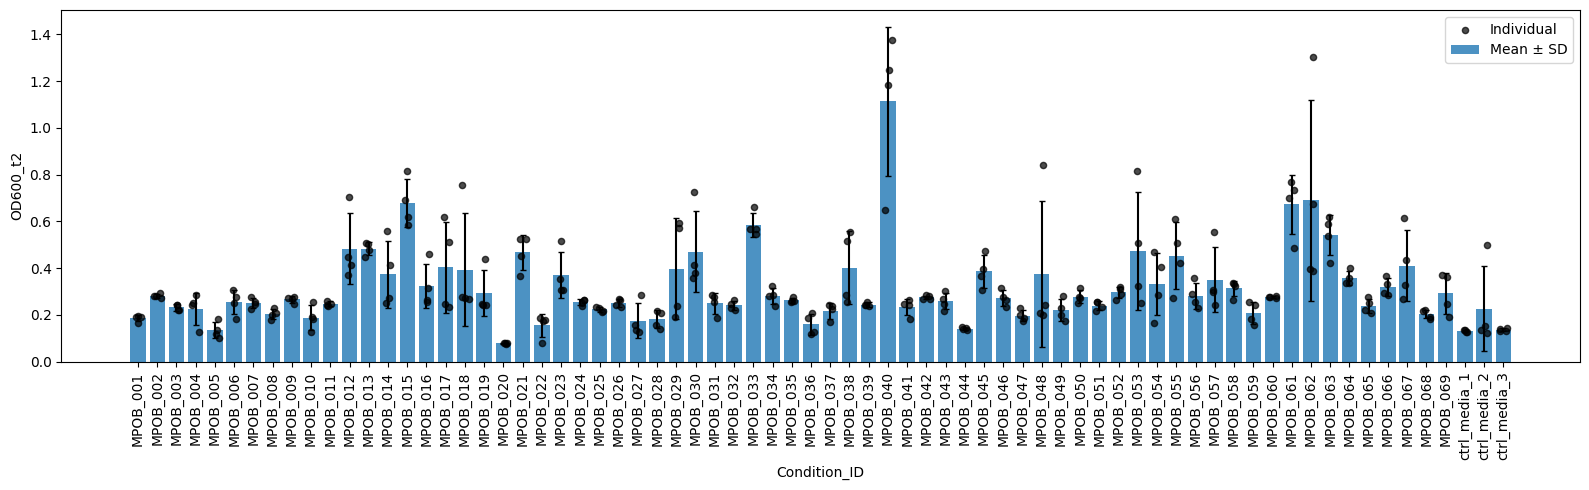

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Bar chart: Condition_ID on x, mean on y, std as error bars
plt.figure(figsize=(16, 5))
x_pos = np.arange(len(df_avg))
plt.bar(x_pos, df_avg["OD600_t2_mean"], yerr=df_avg["OD600_t2_std"], capsize=2, alpha=0.8, label="Mean ± SD")

# Map Condition_ID to bar index (same order as df_avg)
cid_to_idx = {cid: i for i, cid in enumerate(df_avg["Condition_ID"])}
x_index = df["Condition_ID"].map(cid_to_idx).values
x_jitter = x_index + np.random.uniform(-0.2, 0.2, size=len(df))
plt.scatter(x_jitter, df["OD600_t2"], alpha=0.7, color="black", s=20, zorder=3, label="Individual")

plt.xticks(x_pos, df_avg["Condition_ID"], rotation=90)
plt.xlabel("Condition_ID")
plt.ylabel("OD600_t2")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Coefficient of Variation (CV) Analysis

CV table (color-coded: green = low, red = high) and bar chart.

ID,mean,std,CV_%
MPOB_001,0.1850,0.0132,7.12
MPOB_002,0.2808,0.0085,3.02
MPOB_003,0.2316,0.0135,5.81
MPOB_004,0.2260,0.0690,30.55
MPOB_005,0.1350,0.0352,26.09
MPOB_006,0.2534,0.0518,20.43
MPOB_007,0.2499,0.0220,8.8
MPOB_008,0.2043,0.0207,10.13
MPOB_009,0.2666,0.0142,5.32
MPOB_010,0.1885,0.0523,27.77


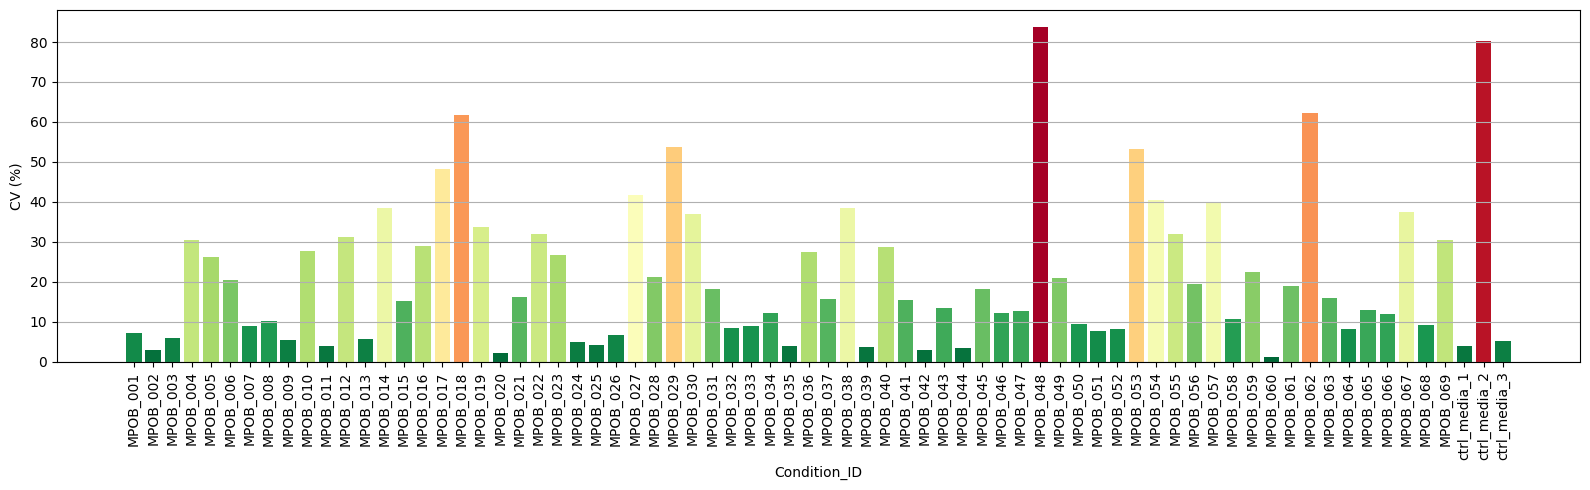

In [31]:
# Table: ID, mean, std, CV (coefficient of variation), with CV color-coded
# (Plain HTML display to avoid pandas.style dependency on jinja2)
from IPython.display import HTML, display

df_table = df_avg[["Condition_ID", "OD600_t2_mean", "OD600_t2_std"]].copy()
df_table = df_table.rename(columns={"Condition_ID": "ID", "OD600_t2_mean": "mean", "OD600_t2_std": "std"})
df_table["CV_%"] = (df_table["std"] / df_table["mean"] * 100).round(2)

# Color-code CV: interpolate green (low) -> red (high)
cv = df_table["CV_%"].values
cmin, cmax = cv.min(), cv.max()
span = (cmax - cmin) or 1

def rgb_for_cv(val):
    t = (val - cmin) / span  # 0 = low, 1 = high
    r = int(34 + (255 - 34) * t)   # green 34,139,34 -> red 255,0,0
    g = int(139 * (1 - t))
    b = int(34 * (1 - t))
    return f"rgb({r},{g},{b})"

rows = ["<tr><th>ID</th><th>mean</th><th>std</th><th>CV_%</th></tr>"]
for _, r in df_table.iterrows():
    bg = rgb_for_cv(r["CV_%"])
    rows.append(f'<tr><td>{r["ID"]}</td><td>{r["mean"]:.4f}</td><td>{r["std"]:.4f}</td><td style="background-color:{bg}">{r["CV_%"]}</td></tr>')
display(HTML("<table>" + "".join(rows) + "</table>"))

# Image of CV variance (bars colored low=green, high=red)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=cmin, vmax=cmax)
cmap = plt.cm.RdYlGn_r
colors = [cmap(norm(v)) for v in df_table["CV_%"]]
plt.figure(figsize=(16, 5))
x_pos = np.arange(len(df_table))
plt.bar(x_pos, df_table["CV_%"], color=colors)
plt.xticks(x_pos, df_table["ID"], rotation=90)
plt.ylabel("CV (%)")
plt.xlabel("Condition_ID")
plt.tight_layout()
#plt.show()
#y axis grid lines
plt.grid(axis='y')
plt.show()
#make a table of the CV variance




ID,mean,std,CV_%
MPOB_001,0.1914,0.0028,1.46
MPOB_002,0.2772,0.0054,1.93
MPOB_003,0.2359,0.0127,5.4
MPOB_004,0.2593,0.0223,8.6
MPOB_005,0.1190,0.0183,15.38
MPOB_006,0.2767,0.0276,9.98
MPOB_007,0.2588,0.0157,6.08
MPOB_008,0.2129,0.0141,6.62
MPOB_009,0.2735,0.0044,1.59
MPOB_010,0.2094,0.0385,18.38


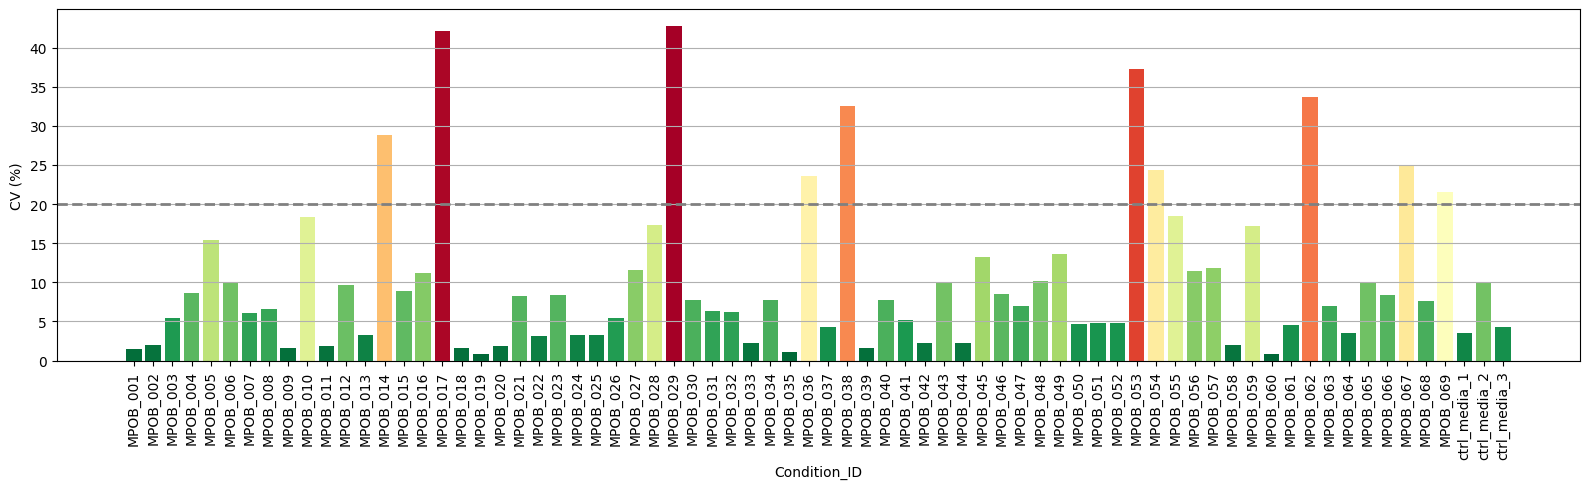

In [32]:
# Identify one outlier replicate per condition (leave-one-out: drop the one that most reduces CV), then triplicates -> CV table + image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import HTML, display

od_col = "OD600_t2"

# Per condition: for groups with >= 4 replicates, find the replicate whose removal minimizes CV
indices_to_drop = []
for cid, grp in df.groupby("Condition_ID"):
    vals = grp[od_col].values
    if len(vals) < 4:
        continue
    best_cv = np.inf
    best_idx = None
    for i in range(len(vals)):
        leave = np.delete(vals, i)
        m, s = leave.mean(), leave.std()
        cv = (s / m * 100) if m > 0 else np.inf
        if cv < best_cv:
            best_cv = cv
            best_idx = grp.index[i]
    if best_idx is not None:
        indices_to_drop.append(best_idx)

df_triplicate = df.drop(index=indices_to_drop)

# Recompute mean and std per condition (triplicates)
df_avg_triplicate = df_triplicate.groupby("Condition_ID")[od_col].mean().to_frame()
df_avg_triplicate = df_avg_triplicate.merge(
    df_triplicate.groupby("Condition_ID")[od_col].std().to_frame(),
    left_index=True, right_index=True, suffixes=("_mean", "_std")
).reset_index()
df_avg_triplicate.columns = ["Condition_ID", "OD600_t2_mean", "OD600_t2_std"]

# CV table (color-coded)
df_table_triplicate = df_avg_triplicate[["Condition_ID", "OD600_t2_mean", "OD600_t2_std"]].copy()
df_table_triplicate = df_table_triplicate.rename(columns={"Condition_ID": "ID", "OD600_t2_mean": "mean", "OD600_t2_std": "std"})
df_table_triplicate["CV_%"] = (df_table_triplicate["std"] / df_table_triplicate["mean"] * 100).round(2)

cv_t = df_table_triplicate["CV_%"].values
cmin_t, cmax_t = cv_t.min(), cv_t.max()
span_t = (cmax_t - cmin_t) or 1

def rgb_for_cv_t(val):
    t = (val - cmin_t) / span_t
    r = int(34 + (255 - 34) * t)
    g = int(139 * (1 - t))
    b = int(34 * (1 - t))
    return f"rgb({r},{g},{b})"

rows_t = ["<tr><th>ID</th><th>mean</th><th>std</th><th>CV_%</th></tr>"]
for _, r in df_table_triplicate.iterrows():
    bg = rgb_for_cv_t(r["CV_%"])
    rows_t.append(f'<tr><td>{r["ID"]}</td><td>{r["mean"]:.4f}</td><td>{r["std"]:.4f}</td><td style="background-color:{bg}">{r["CV_%"]}</td></tr>')
display(HTML("<table>" + "".join(rows_t) + "</table>"))

# CV bar chart (triplicates)
norm_t = mcolors.Normalize(vmin=cmin_t, vmax=cmax_t)
cmap = plt.cm.RdYlGn_r
colors_t = [cmap(norm_t(v)) for v in df_table_triplicate["CV_%"]]
# make a dotted line at CV=20%
plt.figure(figsize=(16, 5))
x_pos = np.arange(len(df_table_triplicate))
plt.bar(x_pos, df_table_triplicate["CV_%"], color=colors_t)
plt.axhline(y=20, color='gray', linestyle='--', linewidth=2, label='CV=20%')
plt.xticks(x_pos, df_table_triplicate["ID"], rotation=90)
plt.ylabel("CV (%)")
plt.xlabel("Condition_ID")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## 4. Outlier Removal (Triplicates)

Leave-one-out: for 4-replicate conditions, drop the replicate whose removal minimizes CV. Recompute mean, std, and CV for triplicates.

In [33]:
# filter to only contain values where CV<20%
df_table_triplicate = df_table_triplicate[df_table_triplicate["CV_%"] < 20]
df_table_triplicate 

,ID,mean,std,CV_%
0,MPOB_001,0.191433,0.002801,1.46
1,MPOB_002,0.277167,0.005352,1.93
2,MPOB_003,0.235900,0.012731,5.40
3,MPOB_004,0.259300,0.022292,8.60
4,MPOB_005,0.119033,0.018301,15.38
...,...,...,...,...
65,MPOB_066,0.302133,0.025195,8.34
67,MPOB_068,0.210467,0.016094,7.65
69,ctrl_media_1,0.132467,0.004738,3.58
70,ctrl_media_2,0.135867,0.013662,10.06


In [34]:
# Merge: one row per Condition_ID with media components + OD600 mean/std
df_one_per_id = df.drop_duplicates(subset=["Condition_ID"], keep="first")
df_combined = df_one_per_id.merge(df_avg, on="Condition_ID", how="left")
df_combined
df_combined.columns

Index(['Condition_ID', 'MPOB_Condition_Number', 'Well', 'plate',
       'Total_Phosphate_mM', '(NH4)2SO4_mM', 'CoCl2 mM', 'Succinate_mM',
       'Methanol_mM', 'PQQ mM', 'OD600_t1', 'OD600_t2', 'OD600_t3',
       'Abs660_t1_arsenazo_assay', 'Abs660_t2_arsenazo_assay',
       'Abs660_t3_arsenazo_assay', 'no_bacteria_Abs660_t1_arsenazo_assay',
       'Nd_uM_t1', 'Nd_uM_t2', 'Nd_uM_t3', 'Nd_uM_no_bacteria_Abs660_t1',
       'OD600_t2_mean', 'OD600_t2_std'],
      dtype='object')

## 5. Filter Low-CV Conditions

Keep only conditions with CV < 20%.

In [35]:
# Filter df_combined to only conditions with CV < 20%
low_cv_ids = df_table_triplicate["ID"].unique()
df_combined = df_combined[df_combined["Condition_ID"].isin(low_cv_ids)]

# Export filtered dataset for downstream use
df_combined.to_csv("../df_combined_low_cv.csv", index=False)



## 6. Combined Dataset

Merge media components with OD600 stats. Filter to low-CV conditions only.

In [36]:
# Filter df_combined to only the following columns
cols = [
    "Condition_ID", "MPOB_Condition_Number", "Total_Phosphate_mM", "(NH4)2SO4_mM",
    "CoCl2 mM", "Succinate_mM", "Methanol_mM", "PQQ mM",
    "OD600_t2_mean", "OD600_t2_std",
]
df_combined = df_combined[cols]
df_combined


,Condition_ID,MPOB_Condition_Number,Total_Phosphate_mM,(NH4)2SO4_mM,CoCl2 mM,Succinate_mM,Methanol_mM,PQQ mM,OD600_t2_mean,OD600_t2_std
0,ctrl_media_1,0,25.000000,50.000000,0.001000,15.000000,125.000000,0.001000,0.130700,0.005240
1,MPOB_001,1,39.385477,98.820672,0.009867,82.400970,131.828435,0.000819,0.184950,0.013167
2,MPOB_002,2,1.977445,61.845081,0.084447,116.506060,138.671974,0.001556,0.280800,0.008479
3,MPOB_003,3,40.145174,76.262129,0.083887,89.732716,72.953863,0.000145,0.231625,0.013460
4,MPOB_004,4,17.965835,30.077485,0.001853,148.955244,22.792991,0.004962,0.226000,0.069042
...,...,...,...,...,...,...,...,...,...,...
65,MPOB_063,63,32.157284,18.027514,0.063413,15.166615,42.667804,0.003661,0.541800,0.085903
66,MPOB_064,64,19.865896,10.259144,0.018828,85.868218,145.213443,0.002206,0.357425,0.029405
67,MPOB_065,65,28.830149,22.619126,0.085001,133.759695,111.986158,0.000112,0.237975,0.030991
68,MPOB_066,66,23.529555,2.252284,0.055162,122.557504,32.619013,0.004613,0.318175,0.038112


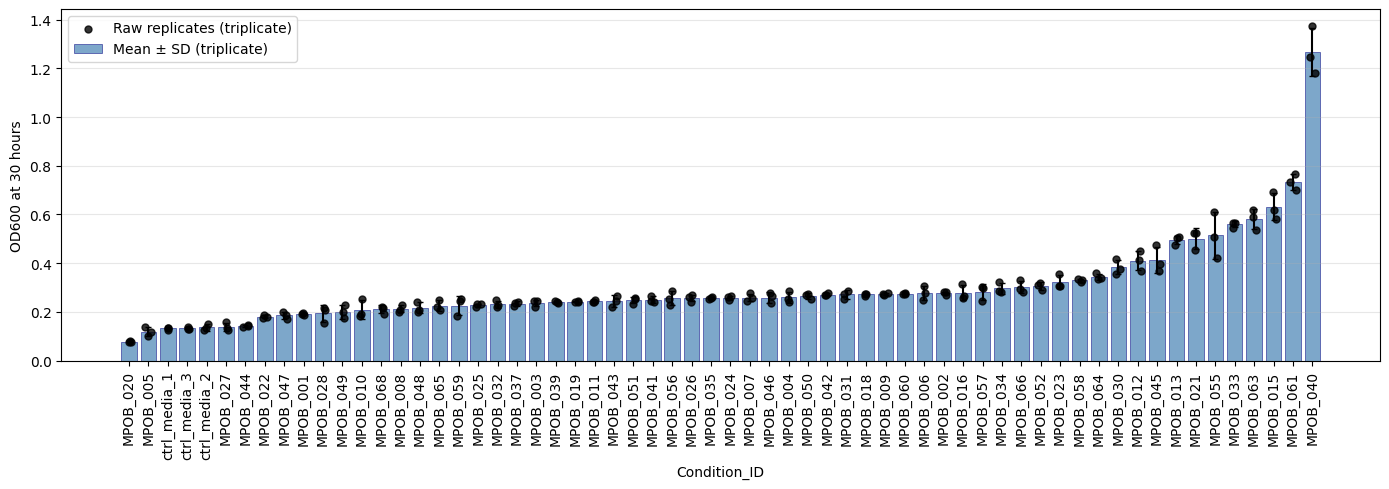

In [37]:
# plot df_combined with std after leave one out, as bar chart; also include raw data points after removing extra datapoint to lead to low CV as scatter plot
import numpy as np
import matplotlib.pyplot as plt

mean_col = "OD600 at 30 hours"
std_col = "OD600_t2_std"
id_col = "Condition_ID"
od_col = "OD600_t2"

# Use mean and std from triplicate data (after leave-one-out) for true representation
triplicate_stats = df_triplicate.groupby(id_col)[od_col].agg(["mean", "std"]).reset_index()
cond_to_stats = triplicate_stats.set_index(id_col).to_dict("index")

# Sort conditions by mean OD600 (low to high) for clearer visualization
all_conds = df_combined[id_col].unique()
cond_means = np.array([cond_to_stats[c]["mean"] if c in cond_to_stats else np.nan for c in all_conds])
sort_ix = np.argsort(cond_means)  # ascending: low OD600 first
sorted_conds = all_conds[sort_ix]

x_pos = np.arange(len(sorted_conds))
means = np.array([cond_to_stats[c]["mean"] if c in cond_to_stats else np.nan for c in sorted_conds])
stds = np.array([cond_to_stats[c]["std"] if c in cond_to_stats else 0 for c in sorted_conds])
stds = np.where(np.isnan(stds), 0, stds)  # single replicate -> std=0

# Raw triplicate points (after leave-one-out): only conditions in df_combined
cond_to_ix = dict(zip(sorted_conds, x_pos))
raw_x, raw_y = [], []
for cid in sorted_conds:
    grp = df_triplicate.loc[df_triplicate[id_col] == cid, od_col]
    if len(grp) > 0:
        ix = cond_to_ix[cid]
        jitter = np.random.uniform(-0.15, 0.15, size=len(grp))
        raw_x.extend(ix + jitter)
        raw_y.extend(grp.values)
raw_x, raw_y = np.array(raw_x), np.array(raw_y)

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x_pos, means, yerr=stds, capsize=2, alpha=0.7, color="steelblue", edgecolor="navy", linewidth=0.5, label="Mean ± SD (triplicate)")
ax.scatter(raw_x, raw_y, color="black", s=25, alpha=0.8, zorder=5, label="Raw replicates (triplicate)")
ax.set_xticks(x_pos)
ax.set_xticklabels(sorted_conds, rotation=90)
ax.set_ylabel(mean_col)
ax.set_xlabel(id_col)
ax.legend(loc="upper left")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Exploratory Plots

Scatter plots, correlation heatmaps, parallel coordinates, and response surfaces.

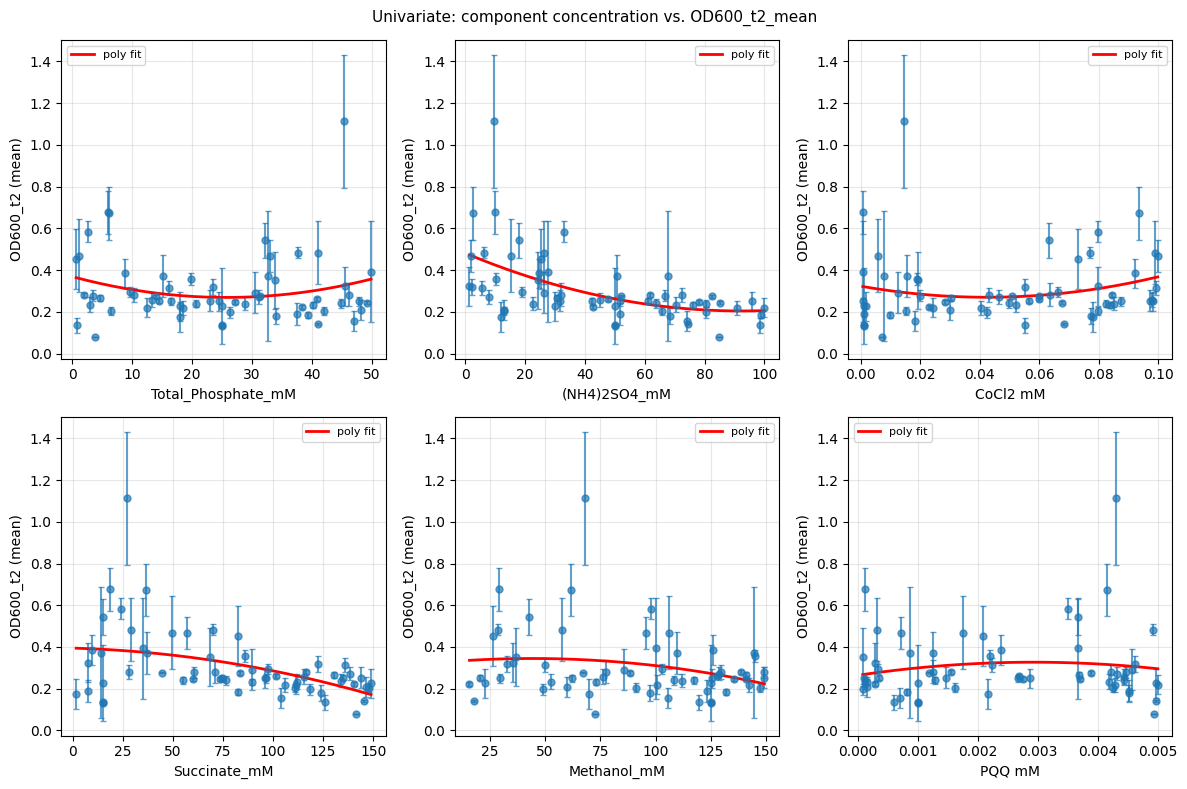

In [38]:
# Univariate exploration: OD vs. each of the 6 components (scatter + polynomial smooth)
import numpy as np
import matplotlib.pyplot as plt

# Six component columns in df_combined (exclude ID and OD columns)
component_cols = [
    "Total_Phosphate_mM", "(NH4)2SO4_mM", "CoCl2 mM",
    "Succinate_mM", "Methanol_mM", "PQQ mM",
]
y_col = "OD600_t2_mean"
degree = 2  # polynomial order for smooth line

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for ax, x_col in zip(axes, component_cols):
    x = df_combined[x_col].values
    y = df_combined[y_col].values
    yerr = df_combined["OD600_t2_std"].values
    ax.errorbar(x, y, yerr=yerr, fmt="o", alpha=0.7, ms=5, capsize=2, capthick=1)
    # Polynomial smooth: sort by x, fit, plot
    order = np.argsort(x)
    x_s, y_s = x[order], y[order]
    p = np.polyfit(x_s, y_s, min(degree, len(np.unique(x_s)) - 1))
    x_line = np.linspace(x_s.min(), x_s.max(), 200)
    ax.plot(x_line, np.polyval(p, x_line), "r-", lw=2, label="poly fit")
    ax.set_xlabel(x_col)
    ax.set_ylabel("OD600_t2 (mean)")
    ax.legend(loc="best", fontsize=8)
    ax.grid(True, alpha=0.3)
plt.suptitle("Univariate: component concentration vs. OD600_t2_mean", fontsize=11)
plt.tight_layout()
plt.show()

Pairwise interactions (2D)

Pairwise scatter plots colored by OD: Create a 6×6 scatterplot matrix of all component pairs, with points colored by OD intensity. This is the quickest way to visually identify interactions — regions of the 2D space where high OD clusters.

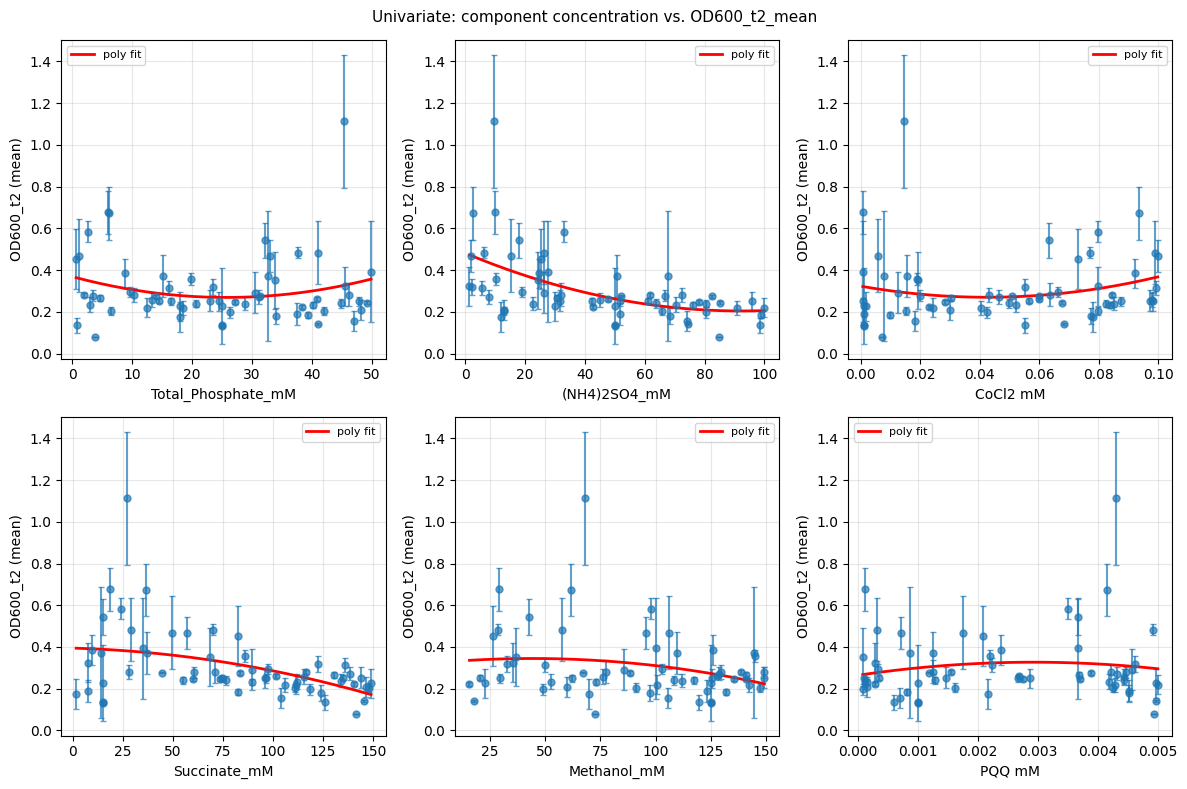

In [39]:

import numpy as np
import matplotlib.pyplot as plt

component_cols = [
    "Total_Phosphate_mM", "(NH4)2SO4_mM", "CoCl2 mM",
    "Succinate_mM", "Methanol_mM", "PQQ mM",
]
y_col = "OD600_t2_mean"
degree = 2

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for ax, x_col in zip(axes, component_cols):
    x = df_combined[x_col].values
    y = df_combined[y_col].values
    yerr = df_combined["OD600_t2_std"].values
    ax.errorbar(x, y, yerr=yerr, fmt="o", alpha=0.7, ms=5, capsize=2, capthick=1)
    order = np.argsort(x)
    x_s, y_s = x[order], y[order]
    deg = min(degree, len(np.unique(x_s)) - 1)
    if deg >= 0:
        p = np.polyfit(x_s, y_s, deg)
        x_line = np.linspace(x_s.min(), x_s.max(), 200)
        ax.plot(x_line, np.polyval(p, x_line), "r-", lw=2, label="poly fit")
    ax.set_xlabel(x_col)
    ax.set_ylabel("OD600_t2 (mean)")
    ax.legend(loc="best", fontsize=8)
    ax.grid(True, alpha=0.3)
plt.suptitle("Univariate: component concentration vs. OD600_t2_mean", fontsize=11)
plt.tight_layout()
plt.show()

Pairwise interactions (2D)

Pairwise scatter plots colored by OD: Create a 6×6 scatterplot matrix of all component pairs, with points colored by OD intensity. This is the quickest way to visually identify interactions — regions of the 2D space where high OD clusters.

/var/folders/s0/nxjrmrgs2jnc3n3d8h35dbpm0000gp/T/ipykernel_39397/3100560482.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


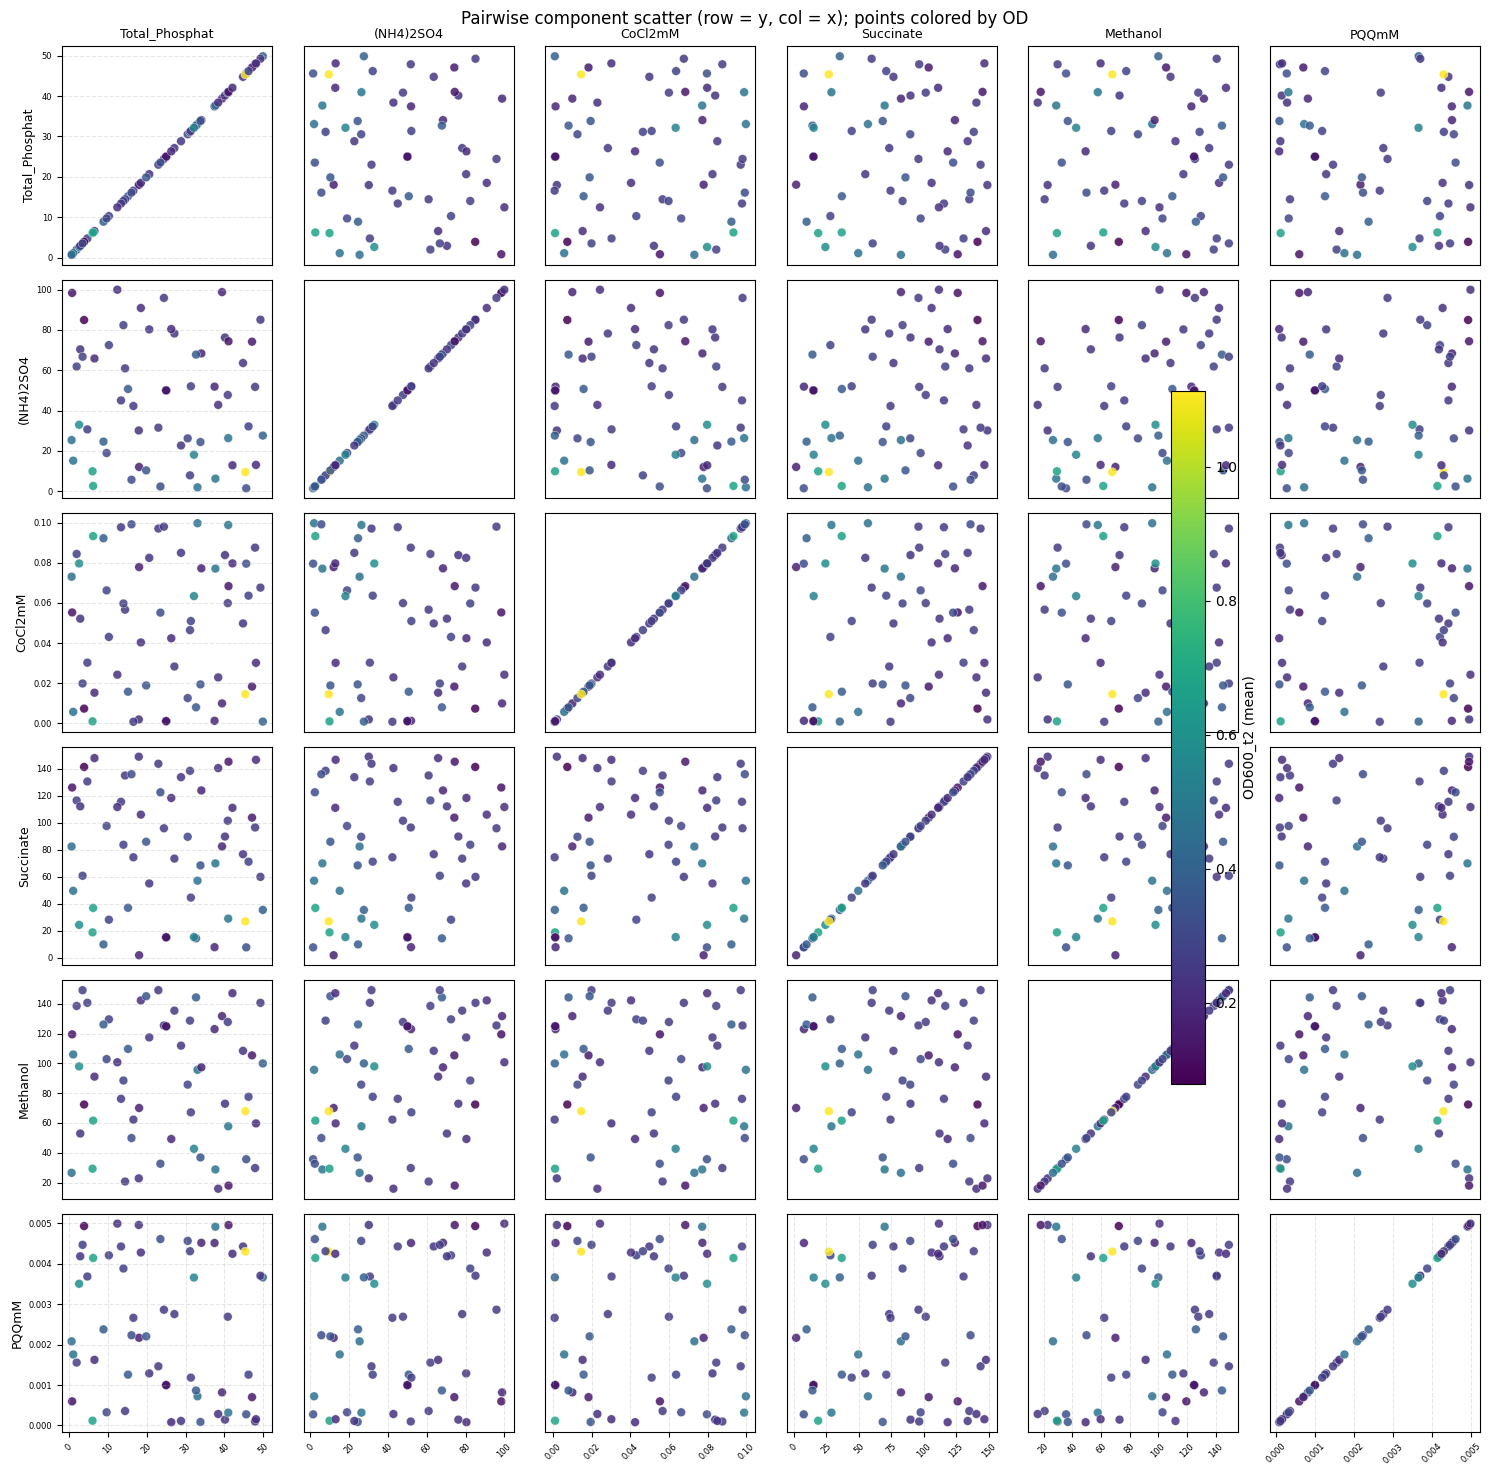

In [40]:
# Pairwise interactions (2D): 6×6 scatter matrix, points colored by OD600_t2_mean
import numpy as np
import matplotlib.pyplot as plt

component_cols = [
    "Total_Phosphate_mM", "(NH4)2SO4_mM", "CoCl2 mM",
    "Succinate_mM", "Methanol_mM", "PQQ mM",
]
y_col = "OD600_t2_mean"
c = df_combined[y_col].values  # color by OD intensity

def short_label(col):
    return col.replace("_mM", "").replace(" ", "").strip()[:14]

fig, axes = plt.subplots(6, 6, figsize=(15, 15))
for i in range(6):
    for j in range(6):
        ax = axes[i, j]
        ax.scatter(
            df_combined[component_cols[j]].values,
            df_combined[component_cols[i]].values,
            c=c, cmap="viridis", s=40, alpha=0.85, edgecolors="white", linewidths=0.3,
        )
        ax.grid(True, alpha=0.3, linestyle="--")
        if i != 5:
            ax.set_xticks([])
        else:
            ax.tick_params(axis="x", labelsize=6, rotation=45)
        if j != 0:
            ax.set_yticks([])
        else:
            ax.tick_params(axis="y", labelsize=6)
        if i == 0:
            ax.set_title(short_label(component_cols[j]), fontsize=9)
        if j == 0:
            ax.set_ylabel(short_label(component_cols[i]), fontsize=9)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=c.min(), vmax=c.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, shrink=0.6, label="OD600_t2 (mean)", pad=0.02)
plt.suptitle("Pairwise component scatter (row = y, col = x); points colored by OD", fontsize=12)
plt.tight_layout()
plt.show()

Compute a Pearson and Spearman correlation matrix between all 6 components and OD. Spearman is important because many media component effects are nonlinear. Visualize as a heatmap.

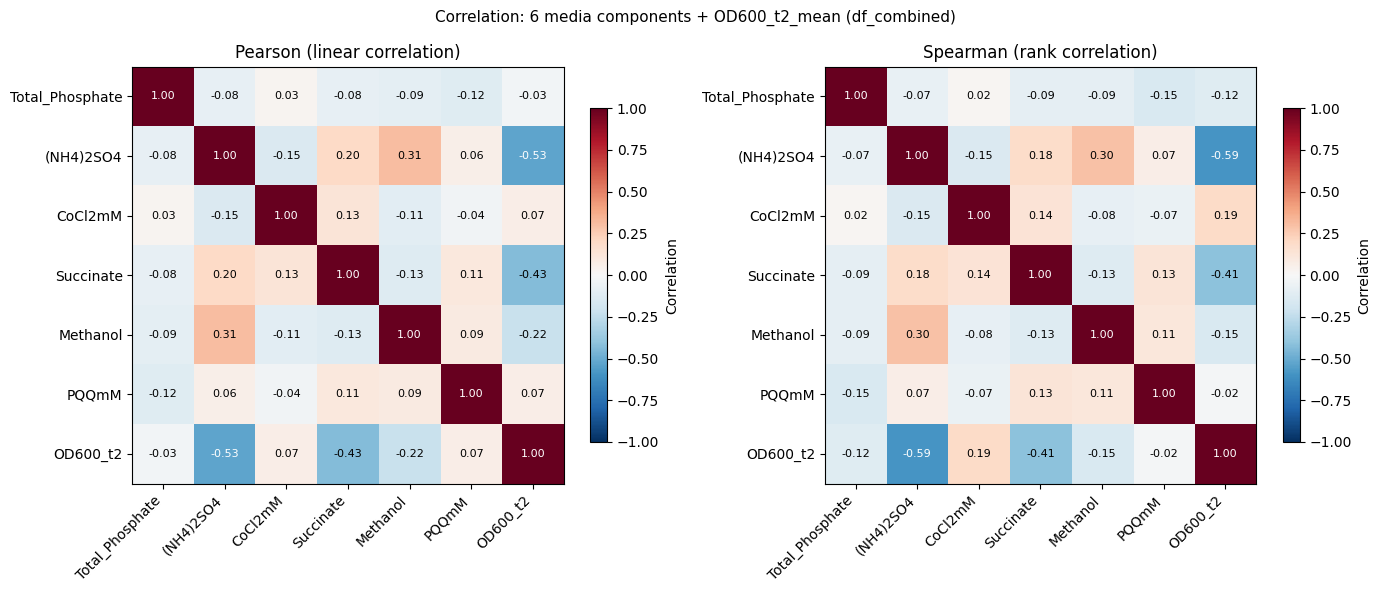

In [41]:
# =============================================================================
# Correlation matrix: Pearson and Spearman (6 components + OD), then heatmaps
# =============================================================================
# REFERENCE / RATIONALE:
# - Pearson r: linear correlation; assumes roughly linear relationship and
#   is sensitive to outliers. Good when effects are linear.
#   See: e.g. Cohen (1988) Statistical Power Analysis for the Behavioral Sciences.
# - Spearman rho: rank correlation; measures monotonic association (linear or
#   nonlinear). Robust to outliers and captures dose-response curves that are
#   monotonic but not linear. Important for media components where effects are
#   often nonlinear (saturation, thresholds). See: Spearman (1904); also
#   pandas doc: DataFrame.corr(method='spearman').
# - Heatmap: 7x7 matrix (6 components + OD); each cell = correlation [-1, 1].
#   Diverging colormap (e.g. RdBu_r) with 0 at center highlights sign and strength.
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt

# Columns to correlate: same 6 media components as elsewhere + OD (mean)
component_cols = [
    "Total_Phosphate_mM", "(NH4)2SO4_mM", "CoCl2 mM",
    "Succinate_mM", "Methanol_mM", "PQQ mM",
]
y_col = "OD600_t2_mean"
corr_cols = component_cols + [y_col]

# Subset to numeric columns only (one row per condition in df_combined)
data = df_combined[corr_cols].copy()

# --- Pearson: linear correlation ---
# r = cov(X,Y) / (sigma_X * sigma_Y); range [-1, 1].
corr_pearson = data.corr(method="pearson")

# --- Spearman: rank correlation ---
# rho = Pearson correlation of the ranks; robust to monotonic nonlinearity.
corr_spearman = data.corr(method="spearman")

# --- Heatmaps (side by side or stacked) ---
# Use diverging colormap: red = positive, blue = negative, white ~ 0.
# vmin=-1, vmax=1 so scale is symmetric.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Short labels for axes (avoid long names overlapping)
labels = [c.replace("_mM", "").replace(" ", "") if c != y_col else "OD600_t2" for c in corr_cols]

for ax, corr_mat, title in [
    (ax1, corr_pearson, "Pearson (linear correlation)"),
    (ax2, corr_spearman, "Spearman (rank correlation)"),
]:
    im = ax.imshow(corr_mat.values, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
    ax.set_xticks(range(len(corr_cols)))
    ax.set_yticks(range(len(corr_cols)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_title(title)
    # Annotate each cell with the correlation value (2 decimals)
    for i in range(len(corr_cols)):
        for j in range(len(corr_cols)):
            val = corr_mat.iloc[i, j]
            color = "white" if abs(val) > 0.5 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color=color)
    plt.colorbar(im, ax=ax, label="Correlation", shrink=0.8)

plt.suptitle("Correlation: 6 media components + OD600_t2_mean (df_combined)", fontsize=11)
plt.tight_layout()
plt.show()

# Optional: print the matrices for the record
# print("Pearson:\n", corr_pearson.round(3))
# print("Spearman:\n", corr_spearman.round(3))

Parallel coordinates plot

This is underused but very informative for media optimization: each line represents one experimental condition, passing through axes for each of the 6 components, with color mapped to OD. You can quickly see which combinations of high/low components lead to good growth.

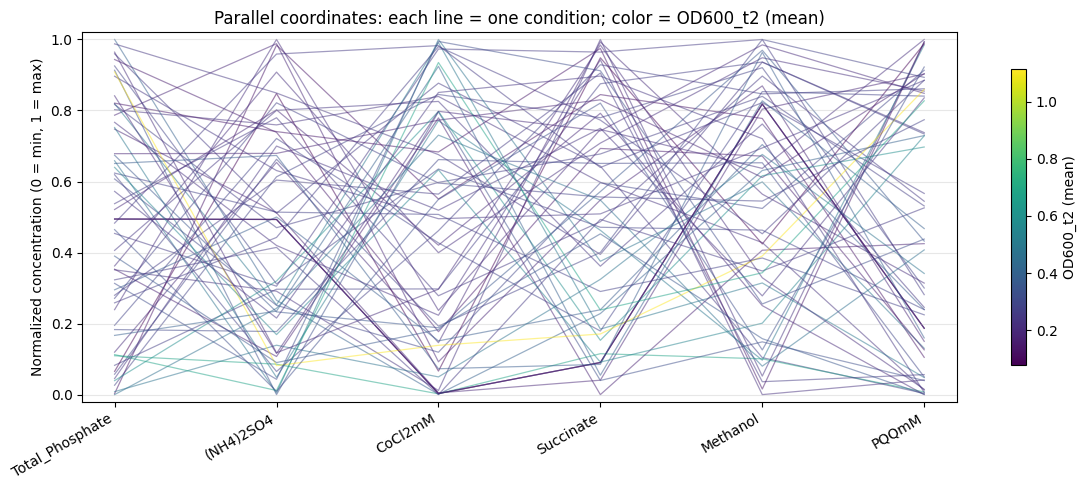

In [42]:
# =============================================================================
# PARALLEL COORDINATES PLOT
# =============================================================================
# WHAT IT SHOWS:
#   - One vertical axis per media component (6 axes). Each axis is the concentration
#     of that component, normalized to [0, 1] so "high" vs "low" is comparable.
#   - One line per experimental condition (row in df_combined): the line connects
#     the condition's value on axis 1, then axis 2, ... then axis 6.
#   - Line color = OD600_t2_mean (e.g. yellow = high growth, purple = low growth).
#   - Use: spot which paths (combinations of high/low across components) tend to
#     give high OD (similar-colored lines clustering) vs low OD.
# REFERENCE: Inselberg (1985) "The plane with parallel coordinates"; useful for
#   high-dimensional data and design-of-experiment visualization.
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

component_cols = [
    "Total_Phosphate_mM", "(NH4)2SO4_mM", "CoCl2 mM",
    "Succinate_mM", "Methanol_mM", "PQQ mM",
]
y_col = "OD600_t2_mean"

# Matrix of concentrations: rows = conditions, columns = components
X = df_combined[component_cols].values
# Normalize each component to [0, 1] so axes are comparable (min=0, max=1 per column)
X_min, X_max = X.min(axis=0), X.max(axis=0)
X_range = (X_max - X_min) + 1e-9  # avoid div by zero if constant column
X_norm = (X - X_min) / X_range

# OD for coloring each line (high OD = one end of colormap)
od = df_combined[y_col].values
norm_od = mcolors.Normalize(vmin=od.min(), vmax=od.max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(12, 5))
x_axes = np.arange(6)

# Draw one line per condition: x = 0..5, y = normalized concentration at each component
for i in range(len(df_combined)):
    color = cmap(norm_od(od[i]))
    ax.plot(x_axes, X_norm[i], color=color, alpha=0.5, linewidth=0.9, zorder=0)

ax.set_xticks(x_axes)
ax.set_xticklabels(
    [c.replace("_mM", "").replace(" ", "").strip() for c in component_cols],
    rotation=30, ha="right",
)
ax.set_ylabel("Normalized concentration (0 = min, 1 = max)")
ax.set_ylim(-0.02, 1.02)
ax.set_xlim(-0.2, 5.2)
ax.grid(True, alpha=0.3, axis="y")
ax.set_title("Parallel coordinates: each line = one condition; color = OD600_t2 (mean)")

# Colorbar for OD
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_od)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label="OD600_t2 (mean)", shrink=0.8)
plt.tight_layout()
plt.show()



**Task:** Create a 2D visualization of (NH4)2SO4 × Succinate colored by OD600_t2_mean to identify the optimal growth region and detect interactions between these two dominant media components.

**Data:** Use the dataframe `df_combined` which contains columns `(NH4)2SO4`, `Succinate`, and `OD600_t2_mean` (plus other columns that can be ignored for now).

**Create a single figure with 2 subplots side by side (1 row × 2 columns), figsize=(16, 7):**

**Left panel — Scatter plot:**
- x-axis: `(NH4)2SO4`, y-axis: `Succinate`
- Each point is one experimental condition
- Color points by `OD600_t2_mean` using the `viridis` colormap (or `RdYlGn` if you prefer green=high growth)
- Point size scaled by OD600_t2_mean (larger = higher OD) using `s = OD600_t2_mean * 300` or similar scaling so points are visible but not overlapping
- Add a colorbar labeled "OD600 (30h)"
- Alpha = 0.8 for slight transparency
- Title: "Scatter: (NH4)2SO4 vs Succinate colored by OD600"

**Right panel — 2D interpolated contour/heatmap:**
- Use `scipy.interpolate.griddata` with method='cubic' to interpolate OD600_t2_mean onto a regular grid across the (NH4)2SO4 × Succinate space
- Create the grid with `np.linspace` from min to max of each variable, 200 points each
- Plot using `plt.contourf` with 20 levels and the same colormap as the scatter
- Overlay the raw data points as small black dots (s=10, color='black') so you can see where data actually exists vs. where the contour is extrapolating
- Add a colorbar labeled "OD600 (30h)"
- Title: "Response Surface: (NH4)2SO4 × Succinate"

**Both panels:**
- x-label: "(NH4)2SO4 concentration"
- y-label: "Succinate concentration"
- Tight layout with `suptitle`: "Growth Response: (NH4)2SO4 × Succinate Interaction"

**Additional annotations:**
- On the scatter plot, find the top 5 highest OD600_t2_mean points and mark them with a red-edged star marker (`marker='*'`, `edgecolors='red'`, `s=200`)
- On the contour plot, mark the interpolated maximum with a red "×" marker and annotate with text showing the approximate optimal (NH4)2SO4 and Succinate concentrations

**Save as:** `NH4_Succinate_interaction.png` at 300 dpi

**Libraries needed:** matplotlib, numpy, scipy.interpolate.griddata, pandas


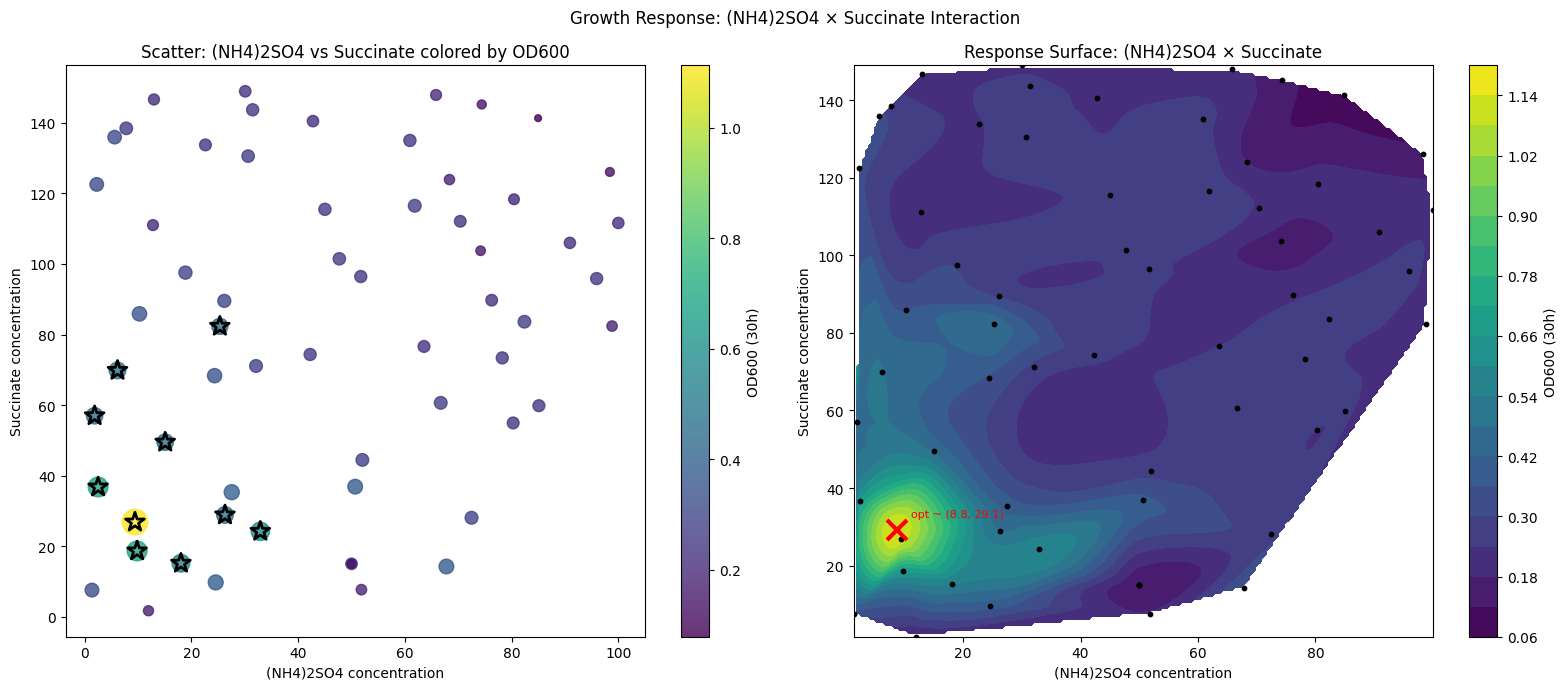

In [43]:
# (NH4)2SO4 × Succinate 2D visualization: scatter + response surface
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
try:
    import mplcursors
    HAS_MPLCURSORS = True
except ImportError:
    HAS_MPLCURSORS = False  # pip install mplcursors for hover-to-show-index

# Column names in df_combined (with _mM suffix)
x_col, y_col = "(NH4)2SO4_mM", "Succinate_mM"
z_col = "OD600_t2_mean"
x = df_combined[x_col].values
y = df_combined[y_col].values
z = df_combined[z_col].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
cmap = "viridis"

# --- Left: Scatter ---
s_scatter = z * 300
sc = ax1.scatter(x, y, c=z, cmap=cmap, s=s_scatter, alpha=0.8)
ax1.set_xlabel("(NH4)2SO4 concentration")
ax1.set_ylabel("Succinate concentration")
ax1.set_title("Scatter: (NH4)2SO4 vs Succinate colored by OD600")
fig.colorbar(sc, ax=ax1, label="OD600 (30h)")

# Top 5 highest OD: red star
top5_idx = np.argsort(z)[-10:]
ax1.scatter(x[top5_idx], y[top5_idx], marker="*", edgecolors="black", s=200, facecolors="none", linewidths=2, zorder=5)

# --- Right: Contour (griddata + contourf) ---
xi = np.linspace(x.min(), x.max(), 200)
yi = np.linspace(y.min(), y.max(), 200)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")
cont = ax2.contourf(Xi, Yi, Zi, levels=20, cmap=cmap)
sc2 = ax2.scatter(x, y, s=10, color="black", zorder=2)
fig.colorbar(cont, ax=ax2, label="OD600 (30h)")
ax2.set_xlabel("(NH4)2SO4 concentration")
ax2.set_ylabel("Succinate concentration")
ax2.set_title("Response Surface: (NH4)2SO4 × Succinate")

# Interpolated maximum (on grid) and annotate
valid = ~np.isnan(Zi)
if np.any(valid):
    flat_idx = np.nanargmax(Zi)
    j_max, i_max = np.unravel_index(flat_idx, Zi.shape)
    x_opt, y_opt = xi[i_max], yi[j_max]
    z_opt = Zi[j_max, i_max]
    ax2.plot(x_opt, y_opt, "x", color="red", markersize=14, markeredgewidth=3, zorder=5)
    ax2.annotate(f"opt ~ ({x_opt:.1f}, {y_opt:.1f})", (x_opt, y_opt), xytext=(10, 10), textcoords="offset points", fontsize=8, color="red")

# Hover: show index and Condition_ID when cursor over points (requires: pip install mplcursors)
if HAS_MPLCURSORS:
    cursor1 = mplcursors.cursor(sc, hover=True)
    @cursor1.connect("add")
    def on_add1(sel):
        idx = sel.index
        cid = df_combined.iloc[idx]["Condition_ID"] if "Condition_ID" in df_combined.columns else ""
        sel.annotation.set_text(f"Index: {idx}\n{cid}\nOD600: {z[idx]:.3f}")
        sel.annotation.get_bbox_patch().set(alpha=0.9)
    cursor2 = mplcursors.cursor(sc2, hover=True)
    @cursor2.connect("add")
    def on_add2(sel):
        idx = sel.index
        sel.annotation.set_text(f"Index: {idx}\nOD600: {z[idx]:.3f}")
        sel.annotation.get_bbox_patch().set(alpha=0.9)

plt.suptitle("Growth Response: (NH4)2SO4 × Succinate Interaction")
plt.tight_layout()
plt.savefig("NH4_Succinate_interaction.png", dpi=300)
plt.show()

In [44]:
# Hover-to-show-index is now integrated into the response surface plot cells above.
# Run the (NH4)2SO4 × Succinate or Methanol × Succinate cell to get interactive hover.


**Task:** Create a 2D visualization of methanol × Succinate colored by OD600_t2_mean to identify the optimal growth region and detect interactions between these two dominant media components.

**Data:** Use the dataframe `df_combined` which contains columns methanol, `Succinate`, and `OD600_t2_mean` (plus other columns that can be ignored for now).

**Create a single figure with 2 subplots side by side (1 row × 2 columns), figsize=(16, 7):**

**Left panel — Scatter plot:**
- x-axis: `methanol, y-axis: `Succinate`
- Each point is one experimental condition
- Color points by `OD600_t2_mean` using the `viridis` colormap (or `RdYlGn` if you prefer green=high growth)
- Point size scaled by OD600_t2_mean (larger = higher OD) using `s = OD600_t2_mean * 300` or similar scaling so points are visible but not overlapping
- Add a colorbar labeled "OD600 (30h)"
- Alpha = 0.8 for slight transparency
- Title: "Scatter: (NH4)2SO4 vs Succinate colored by OD600"

**Right panel — 2D interpolated contour/heatmap:**
- Use `scipy.interpolate.griddata` with method='cubic' to interpolate OD600_t2_mean onto a regular grid across the (NH4)2SO4 × Succinate space
- Create the grid with `np.linspace` from min to max of each variable, 200 points each
- Plot using `plt.contourf` with 20 levels and the same colormap as the scatter
- Overlay the raw data points as small black dots (s=10, color='black') so you can see where data actually exists vs. where the contour is extrapolating
- Add a colorbar labeled "OD600 (30h)"
- Title: "Response Surface: methanol × Succinate"

**Both panels:**
- x-label: "methanol concentration"
- y-label: "Succinate concentration"
- Tight layout with `suptitle`: "Growth Response: (NH4)2SO4 × Succinate Interaction"

**Additional annotations:**
- On the scatter plot, find the top 5 highest OD600_t2_mean points and mark them with a red-edged star marker (`marker='*'`, `edgecolors='red'`, `s=200`)
- On the contour plot, mark the interpolated maximum with a red "×" marker and annotate with text showing the approximate optimal (NH4)2SO4 and Succinate concentrations

**Save as:** `Methanol_Succinate_interaction.png` at 300 dpi

**Libraries needed:** matplotlib, numpy, scipy.interpolate.griddata, pandas

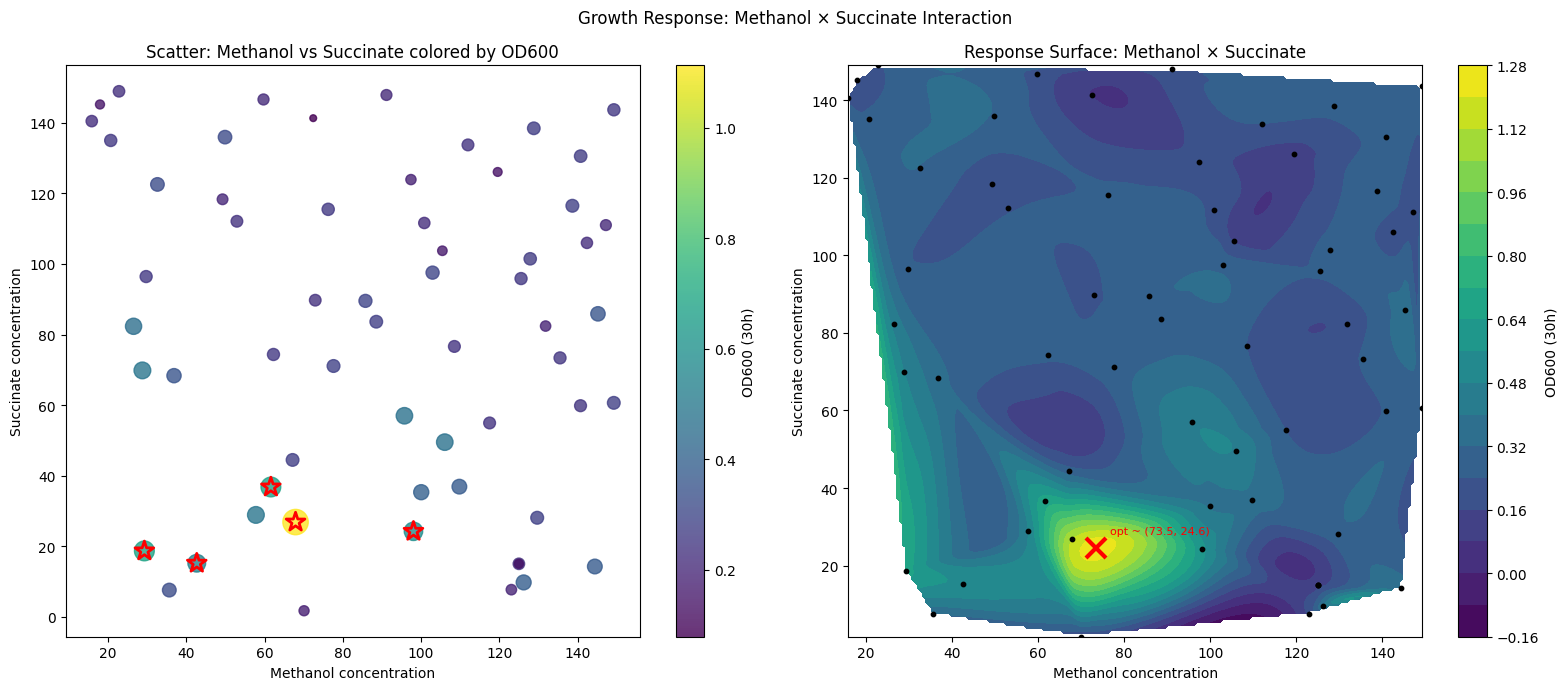

In [45]:
# succinate × methanol 2D visualization: scatter + response surface
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
try:
    import mplcursors
    HAS_MPLCURSORS = True
except ImportError:
    HAS_MPLCURSORS = False  # pip install mplcursors for hover-to-show-index

x_col, y_col = "Methanol_mM", "Succinate_mM"
z_col = "OD600_t2_mean"
x = df_combined[x_col].values
y = df_combined[y_col].values
z = df_combined[z_col].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
cmap = "viridis"

# Left: Scatter
s_scatter = z * 300
sc = ax1.scatter(x, y, c=z, cmap=cmap, s=s_scatter, alpha=0.8)
ax1.set_xlabel("Methanol concentration")
ax1.set_ylabel("Succinate concentration")
ax1.set_title("Scatter: Methanol vs Succinate colored by OD600")
fig.colorbar(sc, ax=ax1, label="OD600 (30h)")
top5_idx = np.argsort(z)[-5:]
ax1.scatter(x[top5_idx], y[top5_idx], marker="*", edgecolors="red", s=200, facecolors="none", linewidths=2, zorder=5)

# Right: Contour
xi = np.linspace(x.min(), x.max(), 200)
yi = np.linspace(y.min(), y.max(), 200)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")
cont = ax2.contourf(Xi, Yi, Zi, levels=20, cmap=cmap)
sc2 = ax2.scatter(x, y, s=10, color="black", zorder=2)
fig.colorbar(cont, ax=ax2, label="OD600 (30h)")
ax2.set_xlabel("Methanol concentration")
ax2.set_ylabel("Succinate concentration")
ax2.set_title("Response Surface: Methanol × Succinate")
if np.any(~np.isnan(Zi)):
    flat_idx = np.nanargmax(Zi)
    j_max, i_max = np.unravel_index(flat_idx, Zi.shape)
    x_opt, y_opt = xi[i_max], yi[j_max]
    ax2.plot(x_opt, y_opt, "x", color="red", markersize=14, markeredgewidth=3, zorder=5)
    ax2.annotate(f"opt ~ ({x_opt:.1f}, {y_opt:.1f})", (x_opt, y_opt), xytext=(10, 10), textcoords="offset points", fontsize=8, color="red")

# Hover: show index and Condition_ID when cursor over points (requires: pip install mplcursors)
if HAS_MPLCURSORS:
    cursor1 = mplcursors.cursor(sc, hover=True)
    @cursor1.connect("add")
    def on_add1(sel):
        idx = sel.index
        cid = df_combined.iloc[idx]["Condition_ID"] if "Condition_ID" in df_combined.columns else ""
        sel.annotation.set_text(f"Index: {idx}\n{cid}\nOD600: {z[idx]:.3f}")
        sel.annotation.get_bbox_patch().set(alpha=0.9)
    cursor2 = mplcursors.cursor(sc2, hover=True)
    @cursor2.connect("add")
    def on_add2(sel):
        idx = sel.index
        sel.annotation.set_text(f"Index: {idx}\nOD600: {z[idx]:.3f}")
        sel.annotation.get_bbox_patch().set(alpha=0.9)

plt.suptitle("Growth Response: Methanol × Succinate Interaction")
plt.tight_layout()
plt.savefig("Methanol_Succinate_interaction.png", dpi=300)
plt.show()

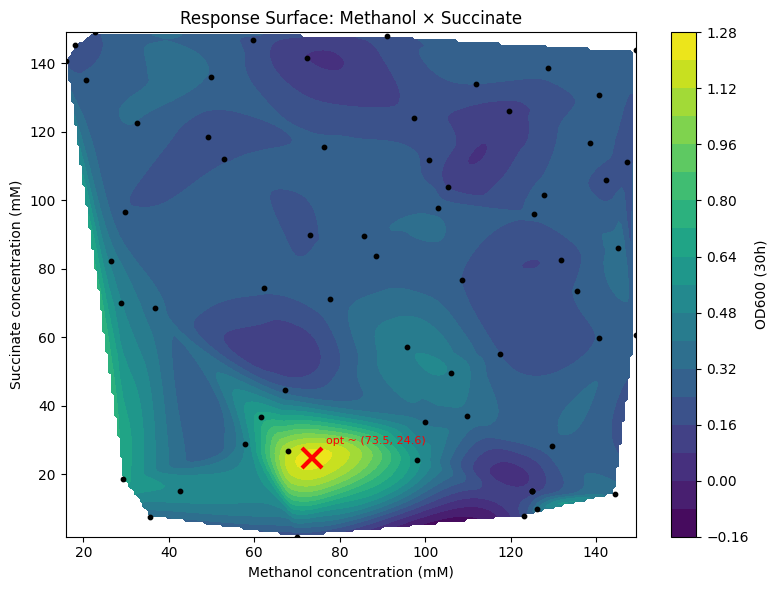

In [46]:
# succinate × methanol 2D visualization: response surface only
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
try:
    import mplcursors
    HAS_MPLCURSORS = True
except ImportError:
    HAS_MPLCURSORS = False

x_col, y_col = "Methanol_mM", "Succinate_mM"
z_col = "OD600_t2_mean"
x = df_combined[x_col].values
y = df_combined[y_col].values
z = df_combined[z_col].values

fig, ax = plt.subplots(figsize=(8, 6))
cmap = "viridis"

xi = np.linspace(x.min(), x.max(), 200)
yi = np.linspace(y.min(), y.max(), 200)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")
cont = ax.contourf(Xi, Yi, Zi, levels=20, cmap=cmap)
sc = ax.scatter(x, y, s=10, color="black", zorder=2)
fig.colorbar(cont, ax=ax, label="OD600 (30h)")
ax.set_xlabel("Methanol concentration (mM)")
ax.set_ylabel("Succinate concentration (mM)")
ax.set_title("Response Surface: Methanol × Succinate")
if np.any(~np.isnan(Zi)):
    flat_idx = np.nanargmax(Zi)
    j_max, i_max = np.unravel_index(flat_idx, Zi.shape)
    x_opt, y_opt = xi[i_max], yi[j_max]
    ax.plot(x_opt, y_opt, "x", color="red", markersize=14, markeredgewidth=3, zorder=5)
    ax.annotate(f"opt ~ ({x_opt:.1f}, {y_opt:.1f})", (x_opt, y_opt), xytext=(10, 10), textcoords="offset points", fontsize=8, color="red")

if HAS_MPLCURSORS:
    cursor = mplcursors.cursor(sc, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        idx = sel.index
        cid = df_combined.iloc[idx]["Condition_ID"] if "Condition_ID" in df_combined.columns else ""
        sel.annotation.set_text(f"Index: {idx}\n{cid}\nOD600: {z[idx]:.3f}")
        sel.annotation.get_bbox_patch().set(alpha=0.9)

plt.tight_layout()
plt.savefig("Methanol_Succinate_interaction.png", dpi=300)
plt.show()

In [50]:
# import df_combined_low_cv.csv as df
import pandas as pd
df_1 = pd.read_csv("df_combined_low_cv.csv")
df_1.columns 

# filter to df_2 with only columns: Condition_ID, media components, OD600_t2_mean
cols = [
    "Condition_ID", "Total_Phosphate_mM", "(NH4)2SO4_mM", "CoCl2 mM",
    "Succinate_mM", "Methanol_mM", "PQQ mM", "OD600_t2_mean",
]
df_2 = df_1[cols].copy()
df_2

FileNotFoundError: [Errno 2] No such file or directory: 'df_combined_low_cv.csv'

In [48]:
#make a plot with phosphate on x axis and OD600_t2_mean on y axis
plt.figure(figsize=(10, 6))
plt.scatter(df_2["Total_Phosphate_mM"], df_2["OD600_t2_mean"], alpha=0.5)
plt.xlabel("Phosphate concentration")
plt.ylabel("OD600_t2_mean")
plt.show()


NameError: name 'df_2' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
#make a plot with phosphate on x axis and ammonium on y axis and color by OD600_t2_mean
plt.figure(figsize=(10, 6))
plt.scatter(df_2["Total_Phosphate_mM"], df_2["(NH4)2SO4_mM"], c=df_2["OD600_t2_mean"], cmap="viridis", alpha=0.5)
plt.xlabel("Phosphate concentration")
plt.ylabel("Ammonium concentration")
plt.colorbar(label="OD600_t2_mean")
plt.show()

In [49]:
# PCA on 6 media components, color by OD600_t2_mean
# Assumes df_2 already exists in memory.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -----------------------------
# 1) Define feature columns + response for coloring
# -----------------------------
feature_cols = [
    'Total_Phosphate_mM',
    '(NH4)2SO4_mM',
    'CoCl2 mM',
    'Succinate_mM',
    'Methanol_mM',
    'PQQ mM'
]
color_col = 'OD600_t2_mean'

# -----------------------------
# 2) Sanity checks + clean subset
# -----------------------------
needed = feature_cols + [color_col]
missing = [c for c in needed if c not in df_2.columns]
if missing:
    raise ValueError(f"Missing columns in df_2: {missing}")

df_pca = df_2[needed].copy()

# Coerce to numeric (handles stray strings/spaces)
for c in needed:
    df_pca[c] = pd.to_numeric(df_pca[c], errors='coerce')

# Drop rows with missing values in features or color
df_pca = df_pca.dropna(subset=needed)

if df_pca.shape[0] < 3:
    raise ValueError("Not enough rows after cleaning to run PCA (need >= 3).")

# -----------------------------
# 3) Standardize features (required for PCA)
# -----------------------------
X = df_pca[feature_cols].values
y = df_pca[color_col].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 4) PCA (2 components)
# -----------------------------
pca = PCA(n_components=2, random_state=42)
PC = pca.fit_transform(X_scaled)

expl_var = pca.explained_variance_ratio_
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=['PC1_loading', 'PC2_loading']
)

# -----------------------------
# 5) Plot PC1 vs PC2 with OD600 color gradient
# -----------------------------
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(
    PC[:, 0], PC[:, 1],
    c=y,  # continuous gradient
    cmap='viridis',  # optional: explicit gradient
    s=60,
    alpha=0.85
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(color_col)

ax.set_xlabel(f"PC1 ({expl_var[0]*100:.1f}% variance)")
ax.set_ylabel(f"PC2 ({expl_var[1]*100:.1f}% variance)")
ax.set_title("PCA of Media Components (colored by OD600_t2_mean)")
ax.axhline(0, linewidth=0.8)
ax.axvline(0, linewidth=0.8)

plt.tight_layout()
plt.show()

# -----------------------------
# 6) Optional: print PCA diagnostics
# -----------------------------
print("Explained variance ratio:", expl_var)
print("\nLoadings (how each component contributes to PCs):")
print(loadings.sort_values('PC1_loading', key=np.abs, ascending=False))

# -----------------------------
# 7) Optional: save PCA scores + loadings
# -----------------------------
pca_scores = df_2.loc[df_pca.index, :].copy()
pca_scores['PC1'] = PC[:, 0]
pca_scores['PC2'] = PC[:, 1]

# pca_scores.to_csv("pca_scores.csv", index=False)
# loadings.to_csv("pca_loadings.csv", index=True)

NameError: name 'df_2' is not defined